In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pdb
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import nltk;
from nltk.corpus import stopwords;

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avichanales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

import spacy
nlp  = spacy.load('en_core_web_md')

### Load Validation Dataset and Model

In [6]:
file_name = '/Users/avichanales/Dropbox/Insight/Project/insight_project/data/interim/charity_data_cleaned.csv'
all_charity = pd.read_csv(file_name)

In [8]:
file_name = '/Users/avichanales/Dropbox/Insight/Project/insight_project/data/interim/validation_set_not_cleaned.csv'
validation_set = pd.read_csv(file_name)

In [83]:
with open('/Users/avichanales/Dropbox/Insight/Project/insight_project/data/processed/charity_model_min_1_max_0.5.pickle', 'rb') as handle:
    charity_model = pickle.load(handle)

In [153]:
def preprocess_spacy(raw_text):
    
    doc = nlp(raw_text)
    
    #Remove organizations and people from documnet text
    tokens_ner = [entity.text for entity in doc.ents if entity.label_ in {'DATE', 'PERSON', 'ORG'}]

    for term in tokens_ner:
        raw_text = raw_text.replace(term,"")
    
    #Re-convert preprocessed text to spacy object    
    doc = nlp(raw_text)


    #Remove stopwords and lemmatize
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]

    return tokens

In [12]:
def process_embed_text(text,charity_docs_dict,charity_model_tfidf,charity_tfidf_emb_vecs):
    
    text_pre = preprocess_spacy(text)
     
    #Convert docs into tf-idf vectors
    doc_corpus = charity_docs_dict.doc2bow(text_pre)
    doc_tfidf  = charity_model_tfidf[doc_corpus]
    doc_vec   = np.vstack([sparse2full(doc_tfidf, len(charity_docs_dict))])
    
    # sum of glove vectors linearlly weighted by tfidf 
    art_emb = np.dot(doc_vec, charity_tfidf_emb_vecs)
    
    
    return art_emb

In [13]:
def compute_similarity_output_n(art_emb,charity_docs_emb,topn):
    
    #compute cosine distance from article embedding to all charities
    sim_to_charities = cosine_similarity(art_emb,charity_docs_emb)
    
    #find topN similarity scores
    sim_scores_sorted = -np.sort(-sim_to_charities).flatten()
    topN_scores = sim_scores_sorted[:topn]
    
    #find topN indices
    indices_sorted = (-sim_to_charities).argsort().flatten()
    topN_indices = indices_sorted[:topn].flatten()
    
    return topN_scores, topN_indices

In [14]:
def topN_ranked_charities(charity_df, topN_scores, topN_indices):
    
    charity_df_slim = charity_df[['name','subcategory','score','description']]
    
    #Extract topN charities and info
    similar_charities = charity_df_slim.iloc[topN_indices].reset_index(drop=True)
    
    #Add their similarity scores
    similar_charities['sim_score'] = topN_scores
    
    return similar_charities

In [151]:
def get_headline_rank(df):
    
    headline = df['title']
    charity_name = df['charity']
    n_charities = df['n_charities']
    
    headline_emb = process_embed_text(headline,
                                      charity_model['charity_docs_dict'],
                                      charity_model['charity_model_tfidf'],
                                      charity_model['charity_tfidf_emb_vecs'])
    
    topN_scores, topN_indices = compute_similarity_output_n(headline_emb,charity_model['charity_docs_emb'],n_charities)
    
    ranked_charities = topN_ranked_charities(all_charity, topN_scores, topN_indices)
    
    pdb.set_trace()
    
    rank = ranked_charities[ranked_charities['name'] == charity_name].index.values.astype(int)[0]
    
    return rank

In [16]:
validation_set['headline_length'] = validation_set.apply(lambda x: len(x['title'].split(" ")),axis=1)

In [17]:
validation_set_trimmed = validation_set[validation_set['headline_length'] >3]

In [ ]:
validation_set_trimmed['n_charities'] = np.shape(charity_model['charity_docs_emb'])[0]

validation_set_trimmed['rank'] = validation_set_trimmed.apply(get_headline_rank,axis=1)


> <ipython-input-151-73aa55631618>(18)get_headline_rank()
-> rank = ranked_charities[ranked_charities['name'] == charity_name].index.values.astype(int)[0]
(Pdb) ranked_charities.head()
                      name                                      subcategory  \
0  The 52nd Street Project  Youth Development, Shelter, and Crisis Services   
1               Childsplay                                  Performing Arts   
2             Tulsa Ballet                                  Performing Arts   
3            Alley Theatre                                  Performing Arts   
4              MCC Theater                                  Performing Arts   

   score                                        description  sim_score  
0  91.70  The 52nd Street Project (The Project) is dedic...   0.804711  
1  88.14  Founded in 1977, Childsplay is a professional ...   0.803079  
2  92.14  The story of Tulsa Ballet began in 1956. Husba...   0.800388  
3  92.13  The Alley Theatre, one of America's le

In [85]:
validation_set_trimmed['rank'].mean()

2647.42489626556

In [82]:
validation_set_trimmed['rank'].mean()

2654.5051777016056

In [19]:
validation_set_trimmed['rank'].mean()

2674.120151542486

In [84]:
validation_set_trimmed['rank'].mean()

2174.871382636656

In [62]:
validation_set['rank'].mean()

2176.1396825396823

In [87]:
validation_set_trimmed['n_charities'].mean()/2

2841.0

In [88]:
rank_by_charity = validation_set_trimmed.groupby('charity')['rank'].mean().reset_index()

In [89]:
rank_by_charity['rank'].mean()

1892.6778376122745

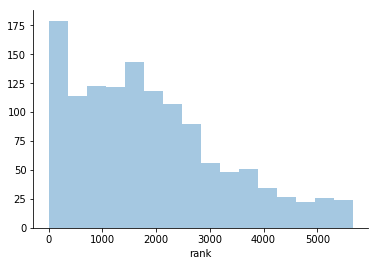

In [90]:
sns.distplot(rank_by_charity['rank'], kde = False)
sns.despine()

In [91]:
rank_by_charity.sort_values(["rank"], axis=0, 
                 ascending=False, inplace=True)

In [92]:
def get_headlines(charity, df):
    df_sub = df[df['charity'] == charity]
    
    return df_sub

In [93]:
def get_mission_statement(charity,df):
    df_sub = df[df['name'] == charity]
    
    return df_sub['description'].iloc[0]

In [130]:
get_mission_statement("Public Justice Center", all_charity)

'The Public Justice Center pursues systemic change to build a just society.'

In [131]:
preprocess_spacy(get_mission_statement("ACLU Foundation of Southern California", all_charity))

[' ',
 'preserve',
 'promote',
 'civil',
 'right',
 'civil',
 'liberty',
 'education',
 'litigation',
 'legal',
 'service',
 'provide',
 'defend',
 'secure',
 'individual',
 'right',
 'Constitution',
 'Bill',
 'Rights',
 'extend',
 'people',
 'exclude',
 'protection']

In [149]:
doc = nlp(u'January')

for entity in doc.ents:
    print(entity.label_)
    if entity.label_ in {'DATE', 'PERSON', 'ORG'}:
        print('found')

DATE
found


In [126]:
tokens = nlp(u'January')

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

January True 6.030409 False


In [138]:
tokens = nlp(u'school')

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov, token.is_stop)

school True 6.7380905 False False


In [132]:
a = get_headlines("ACLU Foundation of Southern California",validation_set_trimmed)

In [143]:
a['title'].iloc[0]

'These LAUSD students are not heading back to school - LA Times'

In [144]:
preprocess_spacy(a['title'].iloc[0])

> <ipython-input-142-cd3776832529>(13)preprocess_spacy()
-> doc = nlp(raw_text)
(Pdb) raw_text
'These LAUSD students are not heading back to '
(Pdb) tokens_ner
['school - LA Times']
(Pdb) exit()


BdbQuit: 

In [96]:
rank_by_charity

,charity,rank
772,National Alopecia Areata Foundation,5663.000000
140,Boston Children's Museum,5653.000000
600,JCC Association of North America,5619.200000
1071,Sierra Club Foundation,5610.000000
299,Commonwealth,5508.187638
1194,Trees for the Future,5477.000000
832,Network for Teaching Entrepreneurship,5476.000000
129,Bet Tzedek,5471.000000
720,Milwaukee Symphony Orchestra,5470.000000
547,Hunter Museum of American Art,5460.000000


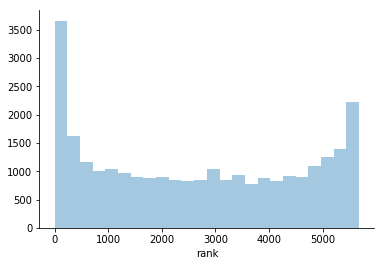

In [28]:
sns.distplot(validation_set_trimmed['rank'],kde = False)
sns.despine()